In [16]:
import requests
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings

import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
from matplotlib import rcParams
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

url = 'https://apis.data.go.kr/1480523/WaterQualityService/getWaterMeasuringList'
key = '8yJUJUA516mCT6EWW5qx4wczXHJvMSZEtuueDB3fhxlXBxkvLuvquPdwtP4CDBkmiHrbiKunquvt/K46xNulRw=='

In [2]:
# 주소에 있던 파라미터 그대로 설정
params = {
    'serviceKey': key,
    'pageNo': '1',
    'numOfRows': '3000',
    'resultType': 'json',
    'ptNoList': '2022A30,2022A10',  # 측정소 코드
    'wmyrList': '2021,2022,2023,2024,2025', # 년
    'wmodList': '01,02,03,04,05,06,07,08,09,10,11,12'   # 월
}

try:
    # API 요청
    response = requests.get(url, params=params, verify=True) # https 대응
    
    if response.status_code == 200:
        data = response.json()
        
        # 데이터 추출 (구조: getWaterMeasuringList -> item)
        items = data.get('getWaterMeasuringList', {}).get('item', [])
        
        if items:
            df = pd.DataFrame(items)
            # df.set_index('ROWNO',inplace=True)

            # 주요 수질 항목 한글 이름으로 변경 (시인성 확보 목적)
            rename_map = {
                'PT_NM': '총량지점명',
                'WMCYMD': '일자',
                'ITEM_TEMP': '수온', # 단위 : ℃
                'ITEM_PH': '수소이온농도(ph)',
                'ITEM_EC': '전기전도도(EC)',    # 단위 : μS/㎝
                'ITEM_DOC': '용존산소(DO)', # 단위 : ㎎/L
                'ITEM_BOD': 'BOD',  # 단위 : ㎎/L
                'ITEM_COD': 'COD',  # 단위 : ㎎/L
                'ITEM_SS': '부유물질',  # 단위 : ㎎/L
                'ITEM_TN': '총질소(T-N)',   # 단위 : ㎎/L
                'ITEM_TP': '총인(T-P)', # 단위 : ㎎/L
                'ITEM_TOC': '총유기탄소(TOC)',  # 단위 : ㎎/L
                'ITEM_AMNT': '유량',    # 단위 : ㎥/s
                'ITEM_CLOA': '클로로필-a'
            }
            
            # 필요한 컬럼만 추출하여 새 DF 생성
            waterDF = df[list(rename_map.keys())].copy()
            waterDF.rename(columns=rename_map, inplace=True)

            # 데이터 타입 숫자형으로 변환 (연산 가능 목적)
            num_cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필-a']
            waterDF[num_cols] = waterDF[num_cols].apply(pd.to_numeric, errors='coerce')

            # 날짜 데이터 형식 변환 (YYYYMMDD -> Datetime형)
            waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce')

            print("--- 분석 준비 완료: 핵심 수질 지표 ---")
            print(waterDF.head())
        else:
            print("응답은 성공했으나 데이터가 없습니다.")
    else:
        print(f"API 요청 실패: {response.status_code}")

except Exception as e:
    print(f"오류 발생: {e}")

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  전기전도도(EC)  용존산소(DO)  BOD  COD  부유물질  \
0    물금 2021-01-04  4.6         7.5      437.0      13.1  1.7  5.1   2.4   
1    물금 2021-01-11  2.8         7.3      461.0      14.3  2.0  5.4   4.0   
2    물금 2021-01-26  5.1         7.2      470.0      15.6  2.1  6.0   7.6   
3    물금 2021-01-18  3.1         7.3      463.0      15.2  2.2  5.9   6.4   
4    물금 2021-02-16  6.6         8.4      451.0      12.1  2.8  6.6  12.4   

   총질소(T-N)  총인(T-P)  총유기탄소(TOC)      유량  클로로필-a  
0     3.223    0.025         3.8  29.555    12.4  
1     3.268    0.031         4.0  28.599    19.4  
2     3.416    0.026         4.6  74.897    47.3  
3     3.327    0.032         4.4  47.190    33.2  
4     3.489    0.027         5.0  72.735    50.4  


In [3]:
# 기술통계값
waterDF.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
수온,404.0,18.056188,8.431139,2.800,10.67500,19.0000,25.22500,32.000
수소이온농도(ph),404.0,7.912376,0.536458,6.500,7.60000,7.9000,8.30000,9.200
전기전도도(EC),404.0,297.460396,107.355447,118.000,206.50000,279.5000,388.00000,516.000
용존산소(DO),404.0,10.372030,2.407574,6.600,8.40000,9.6000,11.92500,16.000
BOD,404.0,1.876485,0.723801,0.400,1.30000,1.7500,2.30000,4.400
COD,404.0,5.998515,1.082983,4.200,5.20000,5.9000,6.60000,11.600
부유물질,404.0,7.247277,7.381532,0.400,3.60000,6.0000,8.80000,100.800
총질소(T-N),404.0,2.449906,0.618431,0.804,2.04225,2.4205,2.91025,3.800
총인(T-P),404.0,0.042918,0.026786,0.015,0.02700,0.0335,0.04900,0.281
총유기탄소(TOC),404.0,3.973762,0.805721,2.100,3.40000,3.9000,4.50000,7.000


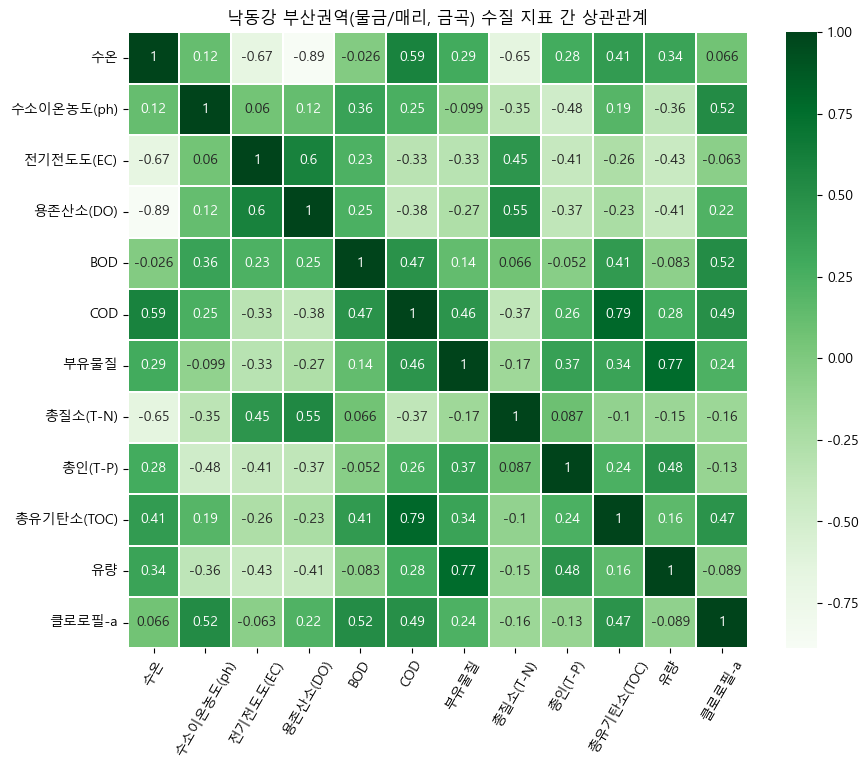

In [4]:
wd = waterDF.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 8))
sb.heatmap(wd, annot=True, linewidths=0.3, cmap='Greens')
plt.xticks(rotation=60)
plt.title("낙동강 부산권역(물금/매리, 금곡) 수질 지표 간 상관관계")

plt.show()

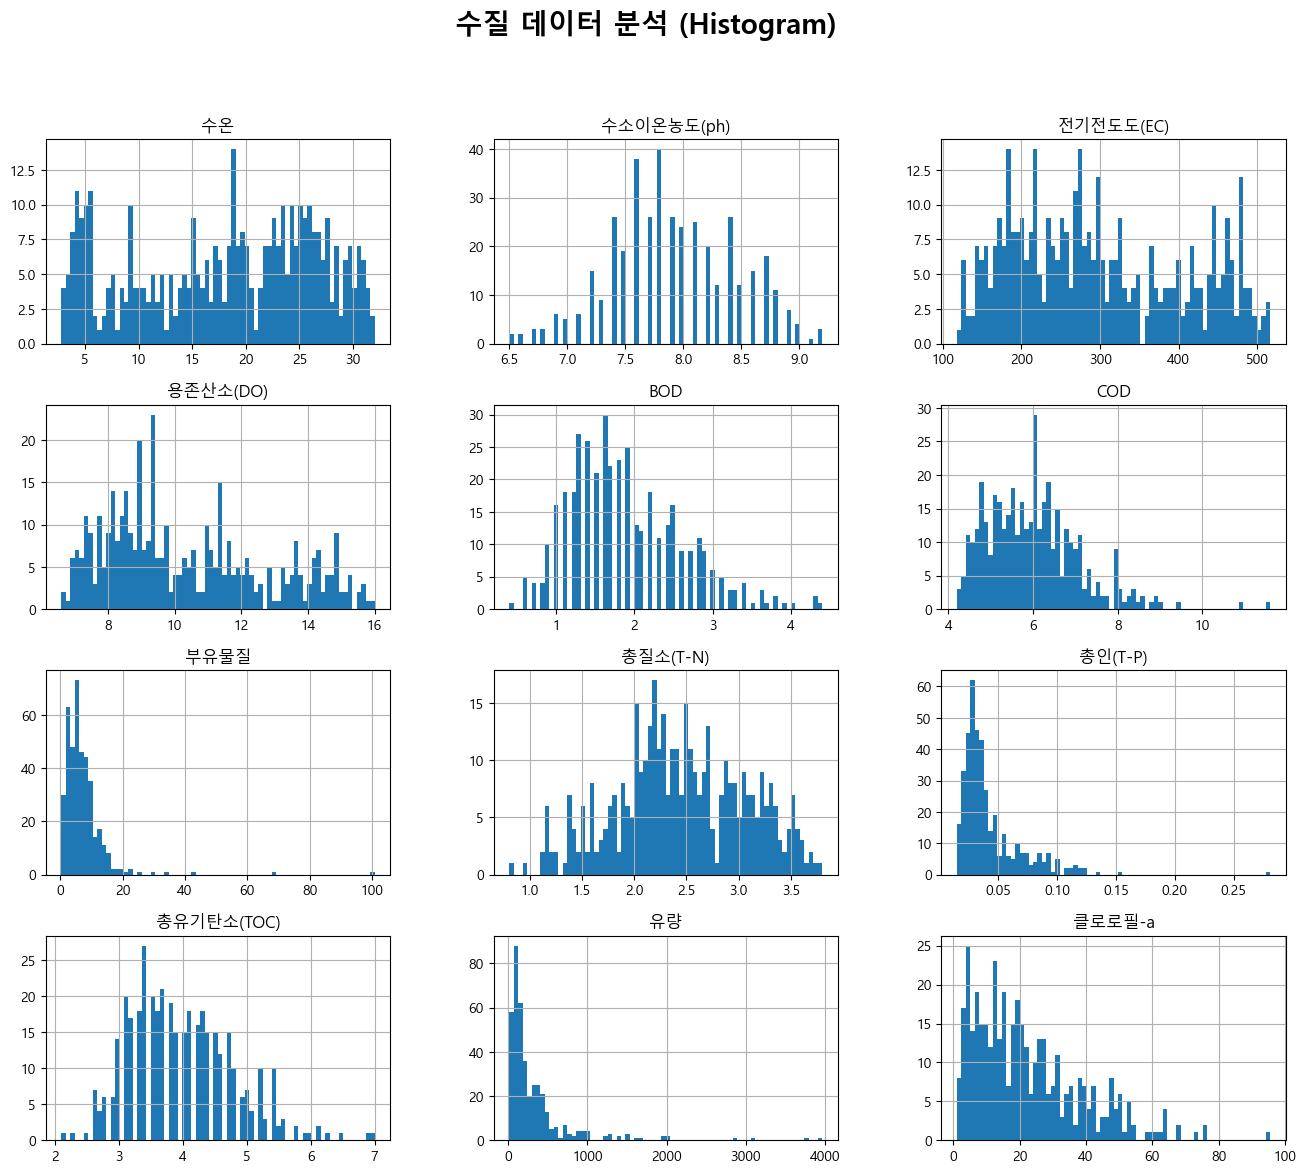

In [5]:
# 전체 데이터에 대한 개괄적인 히스토그램으로 분포 형태, 이상치, 결측치, 시계열/계절성, 데이터 정제 필요성 등 확인
cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량', '클로로필-a']

waterDF[cols].hist(bins=70, figsize=(16, 13))
plt.suptitle('수질 데이터 분석 (Histogram)', fontsize=20, fontweight='bold')

plt.show()

In [6]:
# 부산권역 간 특성이 달라 데이터의 분포 왜곡과 비교분석 오류 방지를 위해 년, 월 컬럼 추가 -> 물금, 금곡으로 분리
waterDF['년'] = waterDF['일자'].dt.year
waterDF['월'] = waterDF['일자'].dt.month

mulgeumDf = waterDF[waterDF['총량지점명'] == '물금'].copy()
geumgogDf = waterDF[waterDF['총량지점명'] == '금곡'].copy()

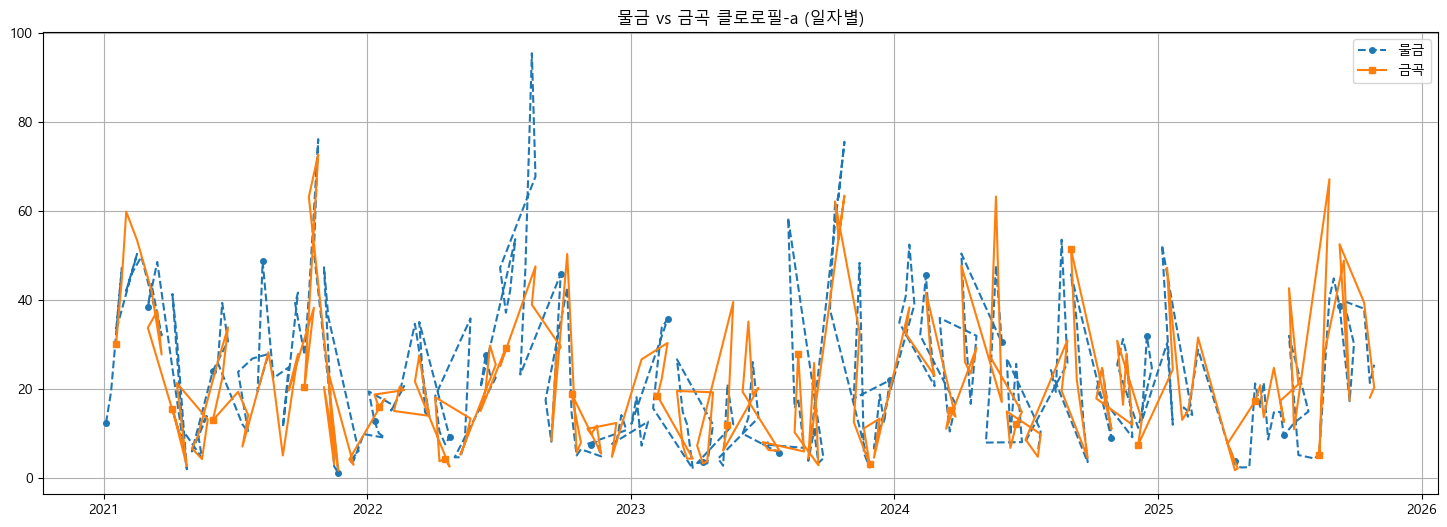

In [7]:
plt.figure(figsize=(18, 6))

plt.plot(mulgeumDf['일자'], mulgeumDf['클로로필-a'], 'o--', markersize=4, markevery=10, label='물금')
plt.plot(geumgogDf['일자'], geumgogDf['클로로필-a'], 's-', markersize=4, markevery=10, label='금곡')
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.legend()
plt.title('물금 vs 금곡 클로로필-a (일자별)')

plt.show()

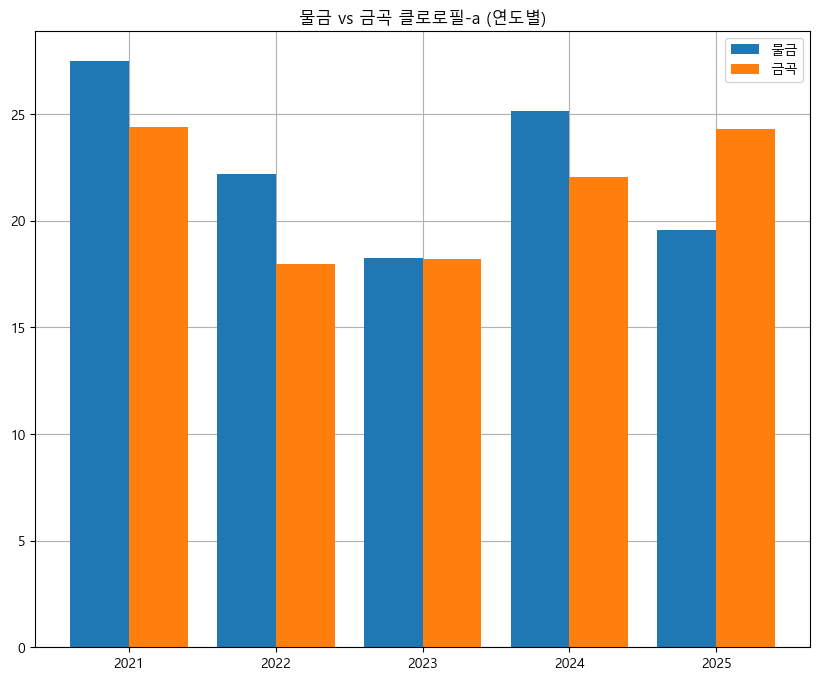

In [8]:
mulgeumDf_a = pd.DataFrame(mulgeumDf.groupby(['년'])['클로로필-a'].mean())
geumgogDf_a = pd.DataFrame(geumgogDf.groupby(['년'])['클로로필-a'].mean())

year = mulgeumDf_a.index.values 
x = np.arange(len(year))
width = 0.4

plt.figure(figsize=(10, 8))
plt.bar(x - width/2, mulgeumDf_a['클로로필-a'], width, label='물금')
plt.bar(x + width/2, geumgogDf_a['클로로필-a'], width, label='금곡')
plt.xticks(x, year)
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.legend()
plt.title('물금 vs 금곡 클로로필-a (연도별)')

plt.show()

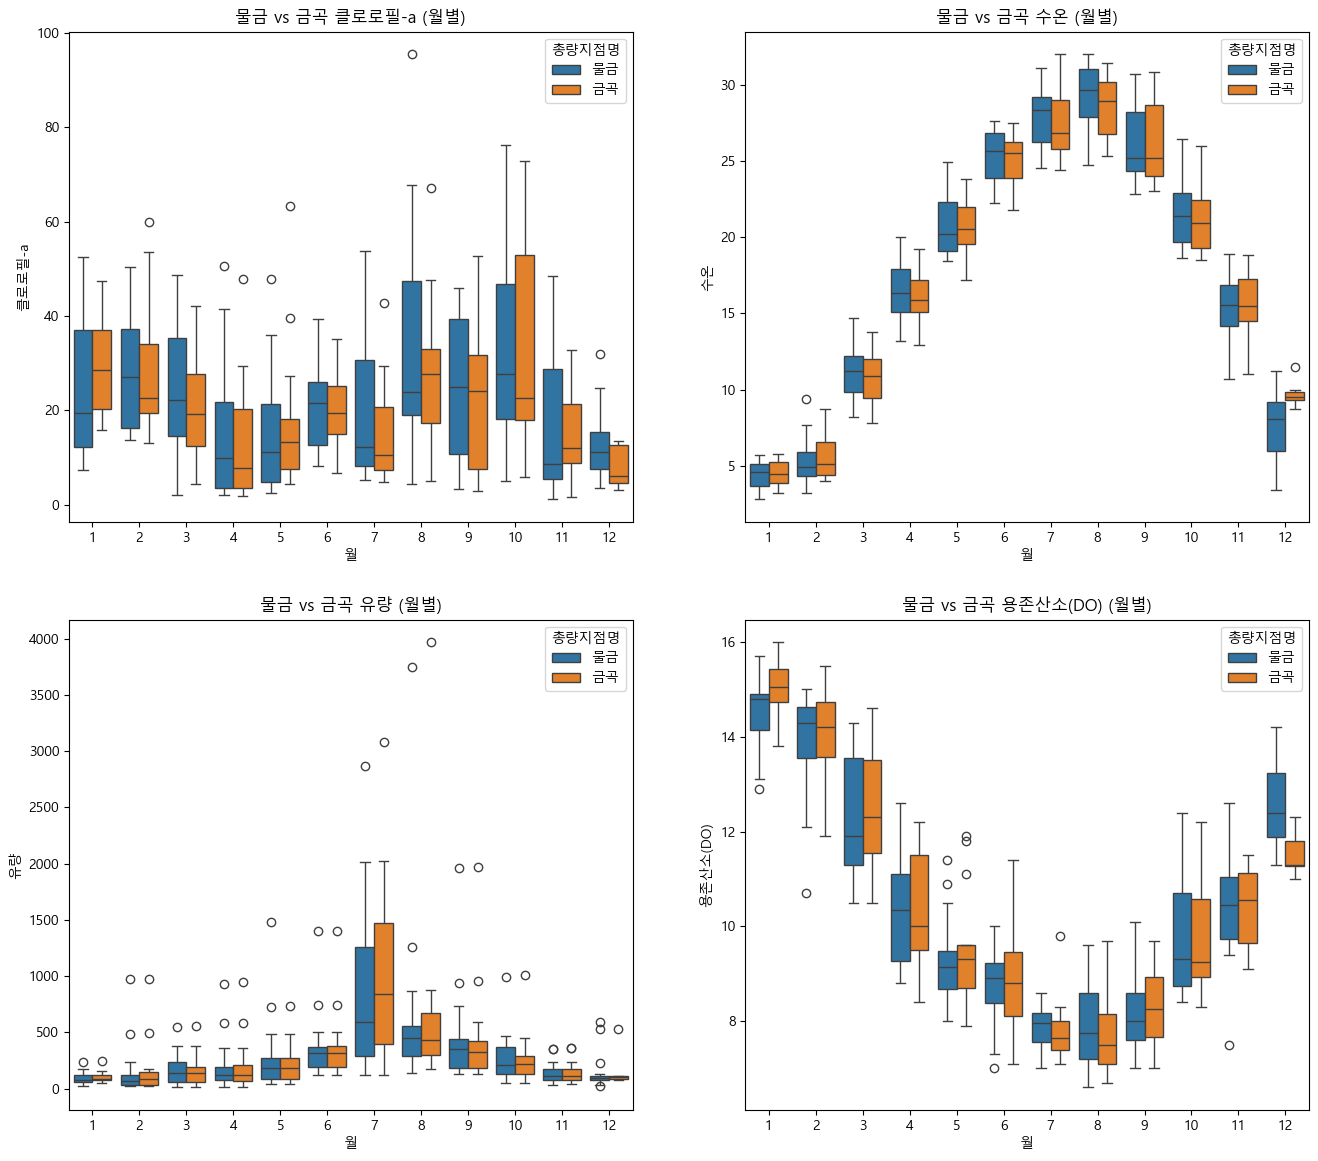

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

sb.boxplot(ax=axes[0,0], x='월', y='클로로필-a', hue='총량지점명', data=waterDF)
axes[0,0].set_title('물금 vs 금곡 클로로필-a (월별)')

sb.boxplot(ax=axes[0,1], x='월', y='수온', hue='총량지점명', data=waterDF)
axes[0,1].set_title('물금 vs 금곡 수온 (월별)')

sb.boxplot(ax=axes[1,0], x='월', y='유량', hue='총량지점명', data=waterDF)
axes[1,0].set_title('물금 vs 금곡 유량 (월별)')

sb.boxplot(ax=axes[1,1], x='월', y='용존산소(DO)', hue='총량지점명', data=waterDF)
axes[1,1].set_title('물금 vs 금곡 용존산소(DO) (월별)')

plt.show()

In [10]:
# 국가 기관(환경부, 국립환경과학원)에서 정한 조류경보제 수치 사용 (클로로필-a 농도가 15 이상이면 '관심', 25 이상이면 '경계'로 분류)
def get_risk_level(chl_a):
    if chl_a < 15:
        return 0    # 정상
    elif chl_a < 25:
        return 1    # 관심
    else:
        return 2    # 경계 이상
    
# 딕셔너리 정의 (나중에 꺼내 쓰기 용도)
risk_map = {0: '정상', 1: '관심', 2: '경계 이상'}

# 새로운 타겟 컬럼 생성
mulgeumDf['위험도'] = mulgeumDf['클로로필-a'].apply(get_risk_level)
geumgogDf['위험도'] = geumgogDf['클로로필-a'].apply(get_risk_level)

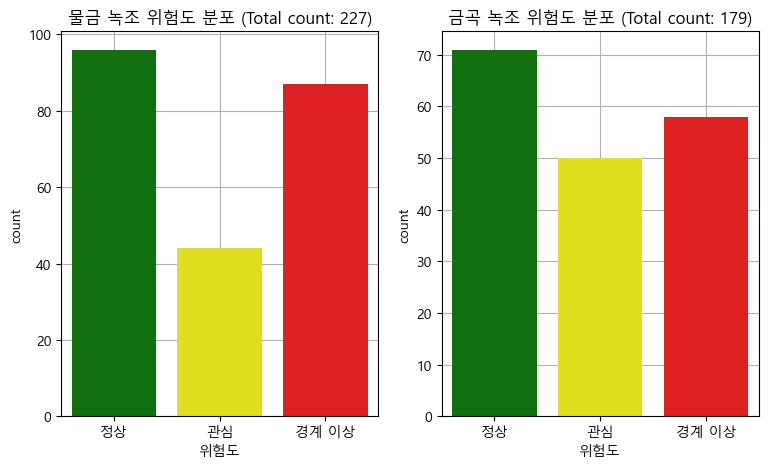

In [11]:
risk_order = ['정상', '관심', '경계 이상']  # 바차트에서 보이는 정렬 지정
risk_palette = {
    '정상': 'green',
    '관심': 'yellow',
    '경계 이상': 'red'
}

plt.figure(figsize=(9, 5))

plt.subplot(1, 2, 1)
sb.countplot(x=mulgeumDf['위험도'].map(risk_map), hue=mulgeumDf['위험도'].map(risk_map), order=risk_order, palette=risk_palette)
plt.title(f'물금 녹조 위험도 분포 (Total count: {len(mulgeumDf["위험도"])})')
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.subplot(1, 2, 2)
sb.countplot(x=geumgogDf['위험도'].map(risk_map), hue=geumgogDf['위험도'].map(risk_map), order=risk_order, palette=risk_palette)
plt.title(f'금곡 녹조 위험도 분포 (Total count: {len(geumgogDf["위험도"])})')
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.show()

In [12]:
# 누적 데이터가 의미 있는 변수들에 대해 1회차 이전(약 1주일 전) 값 생성
lag1 = ['수온', '유량', '총인(T-P)', '총질소(T-N)', '클로로필-a']

for col in lag1:
    mulgeumDf[f'{col}_lag1'] = mulgeumDf[col].shift(1)
    geumgogDf[f'{col}_lag1'] = geumgogDf[col].shift(1)

# 첫 번째 행은 이전 데이터가 없어 NaN이 발생하므로 제거
mulgeumDf = mulgeumDf.dropna()
geumgogDf = geumgogDf.dropna()

In [13]:
# X : 문자열(총량지점명, 일자), 타겟 변수(y) 제외
X_m = mulgeumDf.drop(['총량지점명', '일자', '위험도'], axis=1)
y_m = mulgeumDf['위험도']
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_m, y_m, test_size=0.2, shuffle=False)

X_g = geumgogDf.drop(['총량지점명', '일자', '위험도'], axis=1)
y_g = geumgogDf['위험도']
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_g, y_g, test_size=0.2, shuffle=False)

#### ⭐머신러닝 - 물금

		--- LogisticRegression 사용 ---
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        19
           1       0.42      0.45      0.43        11
           2       0.75      0.80      0.77        15

    accuracy                           0.71        45
   macro avg       0.68      0.68      0.68        45
weighted avg       0.72      0.71      0.72        45



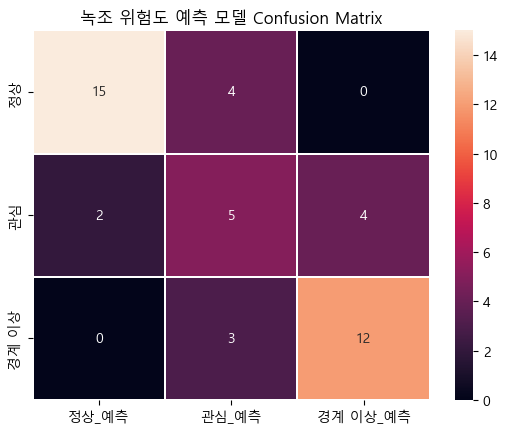

		--- RandomForest 사용 ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       0.83      0.91      0.87        11
           2       1.00      0.87      0.93        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.92        45
weighted avg       0.94      0.93      0.93        45



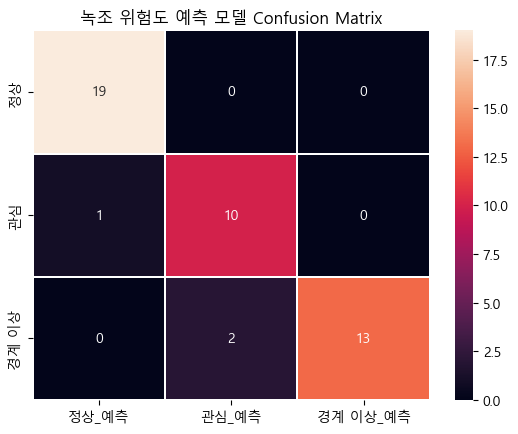

In [ ]:
models = {'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())]), 
          'RandomForest' : Pipeline([('model', RandomForestClassifier(n_estimators=200, random_state=42))])}

for name, model in models.items():
    model.fit(X_train_m, y_train_m)
    y_pred = model.predict(X_test_m)
    c_m = confusion_matrix(y_test_m, y_pred)

    print(f'\t\t--- {name} 사용 ---')
    print(classification_report(y_test_m, y_pred))
    plt.title('녹조 위험도 예측 모델 Confusion Matrix')
    sb.heatmap(c_m, annot=True, fmt='d', linewidths=0.2, xticklabels=['정상_예측', '관심_예측', '경계 이상_예측'], yticklabels=['정상', '관심', '경계 이상'])
    plt.show()

#### ⭐머신러닝 - 금곡

		--- LogisticRegression 사용 ---
              precision    recall  f1-score   support

           0       0.60      0.82      0.69        11
           1       0.71      0.36      0.48        14
           2       0.79      1.00      0.88        11

    accuracy                           0.69        36
   macro avg       0.70      0.73      0.68        36
weighted avg       0.70      0.69      0.67        36



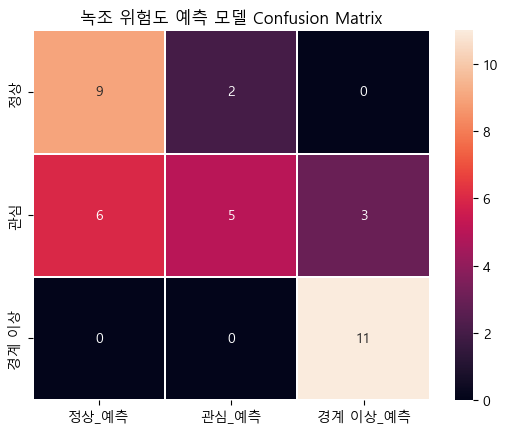

		--- RandomForest 사용 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.86      0.92        14
           2       0.85      1.00      0.92        11

    accuracy                           0.94        36
   macro avg       0.95      0.95      0.95        36
weighted avg       0.95      0.94      0.94        36



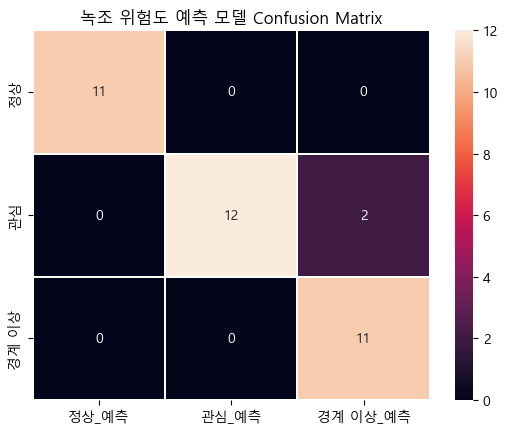

In [27]:
models = {'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())]), 
          'RandomForest' : Pipeline([('model', RandomForestClassifier(n_estimators=200, random_state=42))])}

for name, model in models.items():
    model.fit(X_train_g, y_train_g)
    y_pred = model.predict(X_test_g)
    c_m = confusion_matrix(y_test_g, y_pred)

    print(f'\t\t--- {name} 사용 ---')
    print(classification_report(y_test_g, y_pred))
    plt.title('녹조 위험도 예측 모델 Confusion Matrix')
    sb.heatmap(c_m, annot=True, fmt='d', linewidths=0.2, xticklabels=['정상_예측', '관심_예측', '경계 이상_예측'], yticklabels=['정상', '관심', '경계 이상'])
    plt.show()